In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
# Load data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRC4x6mecC7EkofiP3uJWZ3Y1jD1B2QMZXjlFtdP9-TOan6Fms2TqyOyssHegjTeG7iM6f-qX89vfvK/pub?gid=0&single=true&output=csv"
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'], format='%m-%Y')
df.set_index('Date', inplace=True)
df['Biomass']=df['Biomass'].dropna()

In [3]:
# Assuming df is your DataFrame with the 'Biomass' column
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

# Define look_back period and prepare the dataset
look_back = 5
X, y = create_dataset(df['Biomass'].values, look_back)


In [4]:
# Define a range of parameters for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'base_estimator__max_depth': [3, 5, 10]
}

# Create AdaBoostRegressor with a DecisionTreeRegressor as the base estimator
ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

# Create GridSearchCV
grid_search = GridSearchCV(estimator=ada_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)


In [5]:
# Fit the grid search model
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}


In [6]:
# Train the final model with best parameters
final_ada_model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=best_params['base_estimator__max_depth']),
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate']
)
final_ada_model.fit(X, y)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.1, n_estimators=100)

In [7]:
# Make predictions on the training set
train_predictions = final_ada_model.predict(X)

# Calculate errors
mse = mean_squared_error(y, train_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, train_predictions)
r2 = r2_score(y, train_predictions)

# For MAPE, ensure no division by zero
y_actual_nonzero = np.where(y == 0, np.finfo(float).eps, y)
mape = np.mean(np.abs((y - train_predictions) / y_actual_nonzero)) * 100

# Print the error metrics
print(f"Training Metrics:\nMSE: {mse}\nRMSE: {rmse}\nMAE: {mae}\nMAPE: {mape}\nR-squared: {r2}")


Training Metrics:
MSE: 405.67204984928514
RMSE: 20.141302089221668
MAE: 16.924359145197386
MAPE: 6.479561774215538
R-squared: 0.837463346786909


In [8]:
# Forecast future values for the next 30 months
future_months = 30
future_predictions = []
last_window = df['Biomass'].values[-look_back:]

for _ in range(future_months):
    # Predict the next value
    pred = final_ada_model.predict([last_window])
    future_predictions.append(pred[0])
    # Update the window for the next prediction
    last_window = np.append(last_window[1:], pred)

# Create a time index for the forecasted values
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_months + 1, freq='M')[1:]

# Convert predictions to a pandas Series
future_series = pd.Series(future_predictions, index=future_dates)


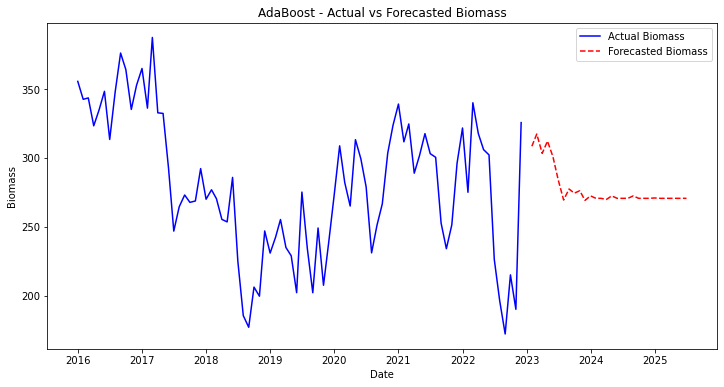

In [9]:
# Plotting the original and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Biomass'], label='Actual Biomass', color='blue')
plt.plot(future_series.index, future_series, label='Forecasted Biomass', color='red', linestyle='dashed')
plt.title('AdaBoost - Actual vs Forecasted Biomass')
plt.xlabel('Date')
plt.ylabel('Biomass')
plt.legend()
plt.show()
